## RENEWAL RATE CLEANING AND CALCULATION

In [1]:
import pandas as pd

from datetime import datetime, timedelta
#import psycopg2
#import plotly.express as px
#import plotly.io as pio
import matplotlib.pyplot as plt
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",999)
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Read the file and drop the first column
lease = pd.read_csv('lease_clean_Nov22.csv', low_memory=False)

In [3]:
lease.shape

(1037215, 43)

In [4]:
lease.shape

(1037215, 43)

In [5]:
#check how many renewal rows are null
lease[lease.renewal.isnull()].shape

(823699, 43)

In [6]:
def standard_ts_format(df, col, dt_format):
    return pd.to_datetime(df[col], format=dt_format)

In [7]:
#data type to timestamp
lease['new_from_date'] = standard_ts_format(lease, 'from_date', '%Y-%m-%d')
lease['new_to_date'] = standard_ts_format(lease, 'to_date','%Y-%m-%d')


In [8]:
lease['new_to_date'] = pd.to_datetime(lease['new_to_date'] )

In [9]:
# lease.dtypes

## Renewal imputation

#### Filter the rows which are currently occupied

In [10]:

occupied_leases = lease[lease['currently_occupied_fl'] == 'Y']
print(occupied_leases.shape)

occupied_leases[occupied_leases['renewal'].isnull()].shape

#make the column names even
occupied_leases['new_renewal_from_year'] = occupied_leases['year_from']
occupied_leases['new_renewal_from_date'] = occupied_leases['new_from_date']
occupied_leases['new_renewal_to_date'] = occupied_leases['new_to_date']

occupied_leases.shape

(267206, 43)


(267206, 46)

#### Filter the rows which are not currently occupied

In [11]:
lease = lease[lease['currently_occupied_fl'] == 'N']
print(lease.shape)

(770009, 43)


#### Further break this down into two parts- where renewal is null and where renewal is not null

In [12]:
#Renewal is null
renewal_null_df = lease[lease['renewal'].isnull()]
print(renewal_null_df.shape)

(584562, 43)


In [13]:
#Renewal is not null
renewal_not_null_df = lease[lease['renewal'].notnull()]
print(renewal_not_null_df.shape)
renewal_not_null_df.head(2)

(185447, 43)


,leasedeal_id,property_id,renewal,from_date,to_date,lease_sign_date,lease_expiration_date,lease_term_in_months,rate_actual,estimated_rent,actual_esti_rent_ratio,service_type_id,property_type_id,location_occupancy_id,rba,tenant_improvement_allowance_persqft,free_months,construction_year,building_rating_id,research_market_name,cbsaid,cbsa_cities,cbsa_states,cbsa_state_new,submarket_name,zip,currently_occupied_fl,new_from_date,new_to_date,year_from,year_to,years_occupied,occupied_months,sqft_min,sqft_max,date_on_market,date_off_market,days_on_market,actual_vacancy,year_on_market,year_off_market,vacant_months,from_const_diff
11,60001976,157084,0.0,1996-06-01,1999-05-31,1996-04-24,2006-05-31,120.0,NaN,38.32,NaN,4.0,5,60001976,17590.0,NaN,NaN,1969.0,5,New York City,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,Columbus Circle,10106.0,N,1996-06-01,1999-05-31,1996,1999.0,3.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-27.0
21,110308081,328017,1.0,2006-04-01,2011-01-24,2006-01-31,2008-04-01,24.0,NaN,18.33,NaN,7.0,5,111485943,9061.0,NaN,NaN,1994.0,3,East Bay/Oakland,36084.0,Oakland-Hayward-Berkeley,CA,CA,Livermore,94551.0,N,2006-04-01,2011-01-24,2006,2011.0,5.0,57.0,9061.0,9061.0,2005-06-30,2006-06-30,365.0,1.0,2005.0,2006.0,12.0,-12.0


In [14]:
#set renewal as 2 if condition is met (occupied - lease term > 12) to duplicate the row later
renewal_null_df['renewal'] = renewal_null_df.apply(lambda x: 2 if ((x['occupied_months'] - int(x['lease_term_in_months']) > 12)) & \
            (pd.isnull(x['renewal'])) else x['renewal'], axis=1)



In [15]:
#add lease term months to from year to get the new_renewal_from_year for all the rows identified as renewal '2'
renewal_null_df['new_renewal_from_year'] = renewal_null_df.apply(lambda x: int(x['year_from']) + int(x['lease_term_in_months']/12) \
                    if x['renewal'] == 2 else x['year_from'], axis=1)

#get new_renewal_from date for calculation of occupied months
renewal_null_df['new_renewal_from_date'] = renewal_null_df.apply(lambda x: x['new_from_date'] + \
                                                pd.DateOffset(months = int(x['lease_term_in_months'])) \
                    if x['renewal'] == 2 else x['new_from_date'], axis=1)

#create new_renewal_to_date for calculation of occupied months
renewal_null_df['new_renewal_to_date'] = renewal_null_df['new_to_date']

#Calculate occupied_months
renewal_null_df['occupied_months'] = (renewal_null_df['new_renewal_to_date'].dt.year - \
                                      renewal_null_df['new_renewal_from_date'].dt.year) * 12 + \
        (renewal_null_df['new_renewal_to_date'].dt.month - renewal_null_df['new_renewal_from_date'].dt.month)

print(renewal_null_df.shape)
renewal_null_df.head()


(584562, 46)


,leasedeal_id,property_id,renewal,from_date,to_date,lease_sign_date,lease_expiration_date,lease_term_in_months,rate_actual,estimated_rent,actual_esti_rent_ratio,service_type_id,property_type_id,location_occupancy_id,rba,tenant_improvement_allowance_persqft,free_months,construction_year,building_rating_id,research_market_name,cbsaid,cbsa_cities,cbsa_states,cbsa_state_new,submarket_name,zip,currently_occupied_fl,new_from_date,new_to_date,year_from,year_to,years_occupied,occupied_months,sqft_min,sqft_max,date_on_market,date_off_market,days_on_market,actual_vacancy,year_on_market,year_off_market,vacant_months,from_const_diff,new_renewal_from_year,new_renewal_from_date,new_renewal_to_date
0,110498312,157648,2.0,2006-10-05,2014-04-29,2006-09-05,2011-10-05,60.0,NaN,39.20,NaN,4.0,5,111764312,3650.0,NaN,NaN,1928.0,3,New York City,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,Murray Hill,10016.0,N,2006-10-05,2014-04-29,2006,2014.0,8.0,30,3650.0,3650.0,2006-03-31,2006-12-31,275.0,1.0,2006.0,2006.0,9.0,-78.0,2011,2011-10-05,2014-04-29
1,30028220,76048,NaN,1982-01-15,2001-04-15,1981-12-16,2000-04-14,219.0,NaN,16.82,NaN,11.0,5,30028220,NaN,NaN,NaN,1977.0,3,Kansas City,28140.0,Kansas City,MO-KS,MO,Ward Parkway,64114.0,N,1982-01-15,2001-04-15,1982,2001.0,19.0,231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,1982,1982-01-15,2001-04-15
2,30187227,559441,NaN,1986-01-15,2000-03-14,1985-12-16,2000-03-14,170.0,NaN,13.45,NaN,NaN,5,30187227,NaN,NaN,NaN,1985.0,2,Kansas City,28140.0,Kansas City,MO-KS,MO,I-29 Corridor,64152.0,N,1986-01-15,2000-03-14,1986,2000.0,14.0,170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,1986,1986-01-15,2000-03-14
3,114096677,239837,NaN,2014-02-14,2015-02-12,2014-01-15,2015-02-13,12.0,NaN,18.91,NaN,7.0,5,122849533,1388.0,NaN,NaN,1972.0,2,Houston,26420.0,Houston-The Woodlands-Sugar Land,TX,TX,Riverway,77024.0,N,2014-02-14,2015-02-12,2014,2015.0,1.0,12,1388.0,1388.0,2013-12-31,2014-03-31,90.0,1.0,2013.0,2014.0,3.0,-42.0,2014,2014-02-14,2015-02-12
5,112542119,158280,NaN,2011-12-01,2016-12-31,2011-11-01,2016-11-30,60.0,NaN,43.79,NaN,4.0,5,119795017,1748.0,NaN,NaN,1890.0,3,New York City,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,Chelsea,10001.0,N,2011-12-01,2016-12-31,2011,2016.0,5.0,60,1748.0,1748.0,2011-09-30,2011-12-31,92.0,1.0,2011.0,2011.0,3.0,-121.0,2011,2011-12-01,2016-12-31


In [16]:
renewal_null_df[renewal_null_df['renewal'] == 2]

,leasedeal_id,property_id,renewal,from_date,to_date,lease_sign_date,lease_expiration_date,lease_term_in_months,rate_actual,estimated_rent,actual_esti_rent_ratio,service_type_id,property_type_id,location_occupancy_id,rba,tenant_improvement_allowance_persqft,free_months,construction_year,building_rating_id,research_market_name,cbsaid,cbsa_cities,cbsa_states,cbsa_state_new,submarket_name,zip,currently_occupied_fl,new_from_date,new_to_date,year_from,year_to,years_occupied,occupied_months,sqft_min,sqft_max,date_on_market,date_off_market,days_on_market,actual_vacancy,year_on_market,year_off_market,vacant_months,from_const_diff,new_renewal_from_year,new_renewal_from_date,new_renewal_to_date
0,110498312,157648,2.0,2006-10-05,2014-04-29,2006-09-05,2011-10-05,60.0,NaN,39.20,NaN,4.0,5,111764312,3650.0,NaN,NaN,1928.0,3,New York City,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,Murray Hill,10016.0,N,2006-10-05,2014-04-29,2006,2014.0,8.0,30,3650.0,3650.0,2006-03-31,2006-12-31,275.0,1.0,2006.0,2006.0,9.0,-78.0,2011,2011-10-05,2014-04-29
6,110870155,5432828,2.0,2007-05-07,2015-07-18,2007-04-09,2012-05-01,60.0,NaN,15.29,NaN,13.0,5,112965808,4341.0,NaN,1.0,1977.0,2,Other Market Areas,47940.0,Waterloo-Cedar Falls,IA,IA,Waterloo-Cedar Falls,50677.0,N,2007-05-07,2015-07-18,2007,2015.0,8.0,38,4340.0,4340.0,2006-12-31,2007-06-30,181.0,1.0,2006.0,2007.0,6.0,-30.0,2012,2012-05-07,2015-07-18
12,110704421,178179,2.0,2007-05-13,2018-06-19,2007-04-13,2012-05-13,60.0,NaN,27.20,NaN,4.0,5,112627998,2400.0,NaN,NaN,1972.0,4,Westchester/So Connecticut,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,West I-287 Corridor,10523.0,N,2007-05-13,2018-06-19,2007,2018.0,11.0,73,2400.0,2400.0,2006-03-31,2007-06-30,456.0,0.0,2006.0,2007.0,15.0,-35.0,2012,2012-05-13,2018-06-19
19,112588249,168474,2.0,2012-01-07,2018-03-21,2012-01-06,2013-01-06,12.0,16.0,22.90,0.7,15.0,5,119885290,655.0,NaN,NaN,1984.0,3,Northern New Jersey,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,North Edison/Woodbridge,8830.0,N,2012-01-07,2018-03-21,2012,2018.0,6.0,62,1725.0,1725.0,2011-09-30,2012-03-31,183.0,1.0,2011.0,2012.0,6.0,-28.0,2013,2013-01-07,2018-03-21
23,111433391,1385898,2.0,2009-03-11,2015-07-18,2009-02-09,2012-03-11,36.0,NaN,16.59,NaN,11.0,5,114304614,2046.0,NaN,NaN,1968.0,2,Other Market Areas,35260.0,New Castle,PA,PA,New Castle,16101.0,N,2009-03-11,2015-07-18,2009,2015.0,6.0,40,2046.0,2046.0,2008-12-31,2009-03-31,90.0,0.0,2008.0,2009.0,3.0,-41.0,2012,2012-03-11,2015-07-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037187,114062582,597155,2.0,2014-01-15,2020-07-27,2013-12-16,2017-01-14,36.0,NaN,35.90,NaN,7.0,5,122712634,1801.0,NaN,NaN,1985.0,4,Orange County (California),11244.0,Anaheim-Santa Ana-Irvine,CA,CA,Newport Beach,92660.0,N,2014-01-15,2020-07-27,2014,2020.0,6.0,42,1801.0,1801.0,2011-09-30,2014-03-31,913.0,1.0,2011.0,2014.0,30.0,-29.0,2017,2017-01-15,2020-07-27
1037189,112770576,621922,2.0,2012-06-15,2018-12-11,2012-05-16,2013-06-14,12.0,NaN,28.16,NaN,1.0,5,120204406,1439.0,NaN,NaN,2003.0,3,Austin,12420.0,Austin-Round Rock,TX,TX,Southwest,78746.0,N,2012-06-15,2018-12-11,2012,2018.0,6.0,66,1439.0,1439.0,2011-12-31,2012-06-30,182.0,1.0,2011.0,2012.0,6.0,-9.0,2013,2013-06-15,2018-12-11
1037202,112123425,240486,2.0,2010-11-17,2015-11-16,2010-08-01,2013-11-16,36.0,NaN,23.48,NaN,7.0,5,118661931,1142.0,NaN,NaN,1968.0,3,Houston,26420.0,Houston-The Woodlands-Sugar Land,TX,TX,Midtown,77006.0,N,2010-11-17,2015-11-16,2010,2015.0,5.0,24,1142.0,1142.0,2009-12-31,2010-12-31,365.0,1.0,2009.0,2010.0,12.0,-42.0,2013,2013-11-17,2015-11-16
1037205,110794275,248465,2.0,2007-07-19,2017-12-31,2007-06-14,2010-07-13,36.0,NaN,19.30,NaN,7.0,5,112788389,3720.0,NaN,1.0,1958.0,3,Los Angeles,31084.0,Los Angeles-Long Beach-Glendale,CA,CA,Park Mile,90010.0,N,2007-07-19,2017-12-31,2007,2017.0,10.0,89,3708.0,3708.0,2007-06-30,2007-09-30,92.0,1.0,2007.0,2007

In [17]:
#duplicate the row with renewal '2'
duplicate_lease_row = renewal_null_df[renewal_null_df['renewal'] == 2]


#set new renewal year as the orignal from year for the leaseid
#Also set the renewal flag as 0
duplicate_lease_row['new_renewal_from_year'] = duplicate_lease_row['year_from']

duplicate_lease_row['new_renewal_from_date'] = pd.to_datetime(duplicate_lease_row['new_from_date'], 
                                                              format='%Y-%m-%d')

duplicate_lease_row['lease_term_in_months'] = duplicate_lease_row['lease_term_in_months'].astype('int')

duplicate_lease_row['new_renewal_to_date'] = duplicate_lease_row.apply(lambda x: x.new_renewal_from_date + \
                                       pd.DateOffset(months=x['lease_term_in_months']), axis=1)

duplicate_lease_row['occupied_months'] = (duplicate_lease_row['new_renewal_to_date'].dt.year - \
                                      duplicate_lease_row['new_renewal_from_date'].dt.year) * 12 + \
        (duplicate_lease_row['new_renewal_to_date'].dt.month - duplicate_lease_row['new_renewal_from_date'].dt.month)

duplicate_lease_row['renewal'] = 0
print(duplicate_lease_row.shape)
duplicate_lease_row

(182899, 46)


,leasedeal_id,property_id,renewal,from_date,to_date,lease_sign_date,lease_expiration_date,lease_term_in_months,rate_actual,estimated_rent,actual_esti_rent_ratio,service_type_id,property_type_id,location_occupancy_id,rba,tenant_improvement_allowance_persqft,free_months,construction_year,building_rating_id,research_market_name,cbsaid,cbsa_cities,cbsa_states,cbsa_state_new,submarket_name,zip,currently_occupied_fl,new_from_date,new_to_date,year_from,year_to,years_occupied,occupied_months,sqft_min,sqft_max,date_on_market,date_off_market,days_on_market,actual_vacancy,year_on_market,year_off_market,vacant_months,from_const_diff,new_renewal_from_year,new_renewal_from_date,new_renewal_to_date
0,110498312,157648,0,2006-10-05,2014-04-29,2006-09-05,2011-10-05,60,NaN,39.20,NaN,4.0,5,111764312,3650.0,NaN,NaN,1928.0,3,New York City,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,Murray Hill,10016.0,N,2006-10-05,2014-04-29,2006,2014.0,8.0,60,3650.0,3650.0,2006-03-31,2006-12-31,275.0,1.0,2006.0,2006.0,9.0,-78.0,2006,2006-10-05,2011-10-05
6,110870155,5432828,0,2007-05-07,2015-07-18,2007-04-09,2012-05-01,60,NaN,15.29,NaN,13.0,5,112965808,4341.0,NaN,1.0,1977.0,2,Other Market Areas,47940.0,Waterloo-Cedar Falls,IA,IA,Waterloo-Cedar Falls,50677.0,N,2007-05-07,2015-07-18,2007,2015.0,8.0,60,4340.0,4340.0,2006-12-31,2007-06-30,181.0,1.0,2006.0,2007.0,6.0,-30.0,2007,2007-05-07,2012-05-07
12,110704421,178179,0,2007-05-13,2018-06-19,2007-04-13,2012-05-13,60,NaN,27.20,NaN,4.0,5,112627998,2400.0,NaN,NaN,1972.0,4,Westchester/So Connecticut,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,West I-287 Corridor,10523.0,N,2007-05-13,2018-06-19,2007,2018.0,11.0,60,2400.0,2400.0,2006-03-31,2007-06-30,456.0,0.0,2006.0,2007.0,15.0,-35.0,2007,2007-05-13,2012-05-13
19,112588249,168474,0,2012-01-07,2018-03-21,2012-01-06,2013-01-06,12,16.0,22.90,0.7,15.0,5,119885290,655.0,NaN,NaN,1984.0,3,Northern New Jersey,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,North Edison/Woodbridge,8830.0,N,2012-01-07,2018-03-21,2012,2018.0,6.0,12,1725.0,1725.0,2011-09-30,2012-03-31,183.0,1.0,2011.0,2012.0,6.0,-28.0,2012,2012-01-07,2013-01-07
23,111433391,1385898,0,2009-03-11,2015-07-18,2009-02-09,2012-03-11,36,NaN,16.59,NaN,11.0,5,114304614,2046.0,NaN,NaN,1968.0,2,Other Market Areas,35260.0,New Castle,PA,PA,New Castle,16101.0,N,2009-03-11,2015-07-18,2009,2015.0,6.0,36,2046.0,2046.0,2008-12-31,2009-03-31,90.0,0.0,2008.0,2009.0,3.0,-41.0,2009,2009-03-11,2012-03-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037187,114062582,597155,0,2014-01-15,2020-07-27,2013-12-16,2017-01-14,36,NaN,35.90,NaN,7.0,5,122712634,1801.0,NaN,NaN,1985.0,4,Orange County (California),11244.0,Anaheim-Santa Ana-Irvine,CA,CA,Newport Beach,92660.0,N,2014-01-15,2020-07-27,2014,2020.0,6.0,36,1801.0,1801.0,2011-09-30,2014-03-31,913.0,1.0,2011.0,2014.0,30.0,-29.0,2014,2014-01-15,2017-01-15
1037189,112770576,621922,0,2012-06-15,2018-12-11,2012-05-16,2013-06-14,12,NaN,28.16,NaN,1.0,5,120204406,1439.0,NaN,NaN,2003.0,3,Austin,12420.0,Austin-Round Rock,TX,TX,Southwest,78746.0,N,2012-06-15,2018-12-11,2012,2018.0,6.0,12,1439.0,1439.0,2011-12-31,2012-06-30,182.0,1.0,2011.0,2012.0,6.0,-9.0,2012,2012-06-15,2013-06-15
1037202,112123425,240486,0,2010-11-17,2015-11-16,2010-08-01,2013-11-16,36,NaN,23.48,NaN,7.0,5,118661931,1142.0,NaN,NaN,1968.0,3,Houston,26420.0,Houston-The Woodlands-Sugar Land,TX,TX,Midtown,77006.0,N,2010-11-17,2015-11-16,2010,2015.0,5.0,36,1142.0,1142.0,2009-12-31,2010-12-31,365.0,1.0,2009.0,2010.0,12.0,-42.0,2010,2010-11-17,2013-11-17
1037205,110794275,248465,0,2007-07-19,2017-12-31,2007-06-14,2010-07-13,36,NaN,19.30,NaN,7.0,5,112788389,3720.0,NaN,1.0,1958.0,3,Los Angeles,31084.0,Los Angeles-Long Beach-Glendale,CA,CA,Park Mile,90010.0,N,2007-07-19,2017-12-31,2007,2017.0,10.0,36,3708.0,3708.0,2007-06-30,2007-09-30,92.0,1.0,2007.0,2007.0,3.0,-49.0,2007,2007-07-19,2010-07

### Re-calculate estimated rent because we have a new renewal from year

In [18]:
renewal_null_df['estimated_rent'] = renewal_null_df.apply(lambda x: x['estimated_rent'] * \
                            (1.02 ** int(x['occupied_months']/12)), axis=1)
renewal_null_df['renewal'] = renewal_null_df.apply(lambda x: 1 if x['renewal'] == 2 else x['renewal'], axis=1)
print(renewal_null_df.shape)

(584562, 46)


In [19]:
renewal_null_df

,leasedeal_id,property_id,renewal,from_date,to_date,lease_sign_date,lease_expiration_date,lease_term_in_months,rate_actual,estimated_rent,actual_esti_rent_ratio,service_type_id,property_type_id,location_occupancy_id,rba,tenant_improvement_allowance_persqft,free_months,construction_year,building_rating_id,research_market_name,cbsaid,cbsa_cities,cbsa_states,cbsa_state_new,submarket_name,zip,currently_occupied_fl,new_from_date,new_to_date,year_from,year_to,years_occupied,occupied_months,sqft_min,sqft_max,date_on_market,date_off_market,days_on_market,actual_vacancy,year_on_market,year_off_market,vacant_months,from_const_diff,new_renewal_from_year,new_renewal_from_date,new_renewal_to_date
0,110498312,157648,1.0,2006-10-05,2014-04-29,2006-09-05,2011-10-05,60.0,NaN,40.783680,NaN,4.0,5,111764312,3650.0,NaN,NaN,1928.0,3,New York City,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,Murray Hill,10016.0,N,2006-10-05,2014-04-29,2006,2014.0,8.0,30,3650.0,3650.0,2006-03-31,2006-12-31,275.0,1.0,2006.0,2006.0,9.0,-78.0,2011,2011-10-05,2014-04-29
1,30028220,76048,NaN,1982-01-15,2001-04-15,1981-12-16,2000-04-14,219.0,NaN,24.503564,NaN,11.0,5,30028220,NaN,NaN,NaN,1977.0,3,Kansas City,28140.0,Kansas City,MO-KS,MO,Ward Parkway,64114.0,N,1982-01-15,2001-04-15,1982,2001.0,19.0,231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,1982,1982-01-15,2001-04-15
2,30187227,559441,NaN,1986-01-15,2000-03-14,1985-12-16,2000-03-14,170.0,NaN,17.746989,NaN,NaN,5,30187227,NaN,NaN,NaN,1985.0,2,Kansas City,28140.0,Kansas City,MO-KS,MO,I-29 Corridor,64152.0,N,1986-01-15,2000-03-14,1986,2000.0,14.0,170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,1986,1986-01-15,2000-03-14
3,114096677,239837,NaN,2014-02-14,2015-02-12,2014-01-15,2015-02-13,12.0,NaN,19.288200,NaN,7.0,5,122849533,1388.0,NaN,NaN,1972.0,2,Houston,26420.0,Houston-The Woodlands-Sugar Land,TX,TX,Riverway,77024.0,N,2014-02-14,2015-02-12,2014,2015.0,1.0,12,1388.0,1388.0,2013-12-31,2014-03-31,90.0,1.0,2013.0,2014.0,3.0,-42.0,2014,2014-02-14,2015-02-12
5,112542119,158280,NaN,2011-12-01,2016-12-31,2011-11-01,2016-11-30,60.0,NaN,48.347698,NaN,4.0,5,119795017,1748.0,NaN,NaN,1890.0,3,New York City,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,Chelsea,10001.0,N,2011-12-01,2016-12-31,2011,2016.0,5.0,60,1748.0,1748.0,2011-09-30,2011-12-31,92.0,1.0,2011.0,2011.0,3.0,-121.0,2011,2011-12-01,2016-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037209,119754101,7314056,NaN,2015-10-10,2016-10-08,2015-09-10,2016-10-09,12.0,NaN,14.453400,NaN,13.0,5,134605381,2032.0,NaN,NaN,2000.0,1,Other Market Areas,27420.0,Jamestown,ND,ND,Jamestown,58401.0,N,2015-10-10,2016-10-08,2015,2016.0,1.0,12,2032.0,2032.0,2009-12-31,2015-12-31,2191.0,1.0,2009.0,2015.0,72.0,-15.0,2015,2015-10-10,2016-10-08
1037210,111384471,300227,1.0,2009-01-01,2016-11-30,2008-11-18,2014-01-01,60.0,NaN,22.379004,NaN,4.0,5,114180680,1750.0,NaN,NaN,1965.0,3,Philadelphia,37980.0,Philadelphia-Camden-Wilmington,PA-NJ-DE-MD,PA,Market Street West,19102.0,N,2009-01-01,2016-11-30,2009,2016.0,7.0,34,1750.0,1750.0,2008-06-30,2009-03-31,274.0,1.0,2008.0,2009.0,9.0,-44.0,2014,2014-01-01,2016-11-30
1037211,30011451,61383,NaN,1988-06-15,1988-06-15,1988-05-16,1997-12-14,114.0,NaN,21.020000,NaN,11.0,5,30011451,NaN,NaN,NaN,1902.0,4,Pittsburgh,38300.0,Pittsburgh,PA,PA,CBD,15219.0,N,1988-06-15,1988-06-15,1988,1988.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-86.0,1988,1988-06-15,1988-06-15
1037213,10541376,303542,NaN,2002-02-01,2002-03-04,2002-01-01,2003-01-31,12.0,NaN,32.400000,NaN,13.0,5,10541376,2395.0,NaN,NaN,1964.0,2,South Bay/San Jose,41940.0,San Jose-Sunnyvale-Santa Clara,CA,CA,Los Gatos/Saratoga,95030.0,N,2002-02-01,2002-03-04,2002,2002.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-38.0,2002,2002-02-01,2002-03-04


In [20]:
renewal = renewal_null_df.append(duplicate_lease_row)
print(renewal.shape)

renewal = renewal.append(renewal_not_null_df)
print(renewal.shape)

renewal = renewal.append(occupied_leases)
print(renewal.shape)

renewal = renewal[~renewal['renewal'].isnull()]
print(renewal.shape)

(767461, 46)
(952908, 46)
(1220114, 46)
(579314, 46)


In [21]:
renewal[renewal['leasedeal_id']==110498312	]

,leasedeal_id,property_id,renewal,from_date,to_date,lease_sign_date,lease_expiration_date,lease_term_in_months,rate_actual,estimated_rent,actual_esti_rent_ratio,service_type_id,property_type_id,location_occupancy_id,rba,tenant_improvement_allowance_persqft,free_months,construction_year,building_rating_id,research_market_name,cbsaid,cbsa_cities,cbsa_states,cbsa_state_new,submarket_name,zip,currently_occupied_fl,new_from_date,new_to_date,year_from,year_to,years_occupied,occupied_months,sqft_min,sqft_max,date_on_market,date_off_market,days_on_market,actual_vacancy,year_on_market,year_off_market,vacant_months,from_const_diff,new_renewal_from_year,new_renewal_from_date,new_renewal_to_date
0,110498312,157648,1.0,2006-10-05,2014-04-29,2006-09-05,2011-10-05,60.0,NaN,40.78368,NaN,4.0,5,111764312,3650.0,NaN,NaN,1928.0,3,New York City,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,Murray Hill,10016.0,N,2006-10-05,2014-04-29,2006,2014.0,8.0,30.0,3650.0,3650.0,2006-03-31,2006-12-31,275.0,1.0,2006.0,2006.0,9.0,-78.0,2011.0,2011-10-05,2014-04-29
0,110498312,157648,0.0,2006-10-05,2014-04-29,2006-09-05,2011-10-05,60.0,NaN,39.20000,NaN,4.0,5,111764312,3650.0,NaN,NaN,1928.0,3,New York City,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,Murray Hill,10016.0,N,2006-10-05,2014-04-29,2006,2014.0,8.0,60.0,3650.0,3650.0,2006-03-31,2006-12-31,275.0,1.0,2006.0,2006.0,9.0,-78.0,2006.0,2006-10-05,2011-10-05


In [22]:
renewal.shape

(579314, 46)

In [23]:
#Change the column data types
renewal['new_renewal_from_year'] = renewal['new_renewal_from_year'].astype('float')
renewal['years_occupied'] = renewal['years_occupied'].astype('Int64')
renewal['year_on_market'] = renewal['year_on_market'].astype('object')
renewal['year_off_market'] = renewal['year_off_market'].astype('object')


### Create a Recession Column

In [24]:
#Create a recession column
recession_years = [2008, 2009]
renewal['recession'] = renewal['new_renewal_from_year'].apply(lambda x: 'Y' if x in recession_years else 'N')
renewal[renewal['recession']=='Y'].shape

(69450, 47)

In [25]:
renewal.head(5)

,leasedeal_id,property_id,renewal,from_date,to_date,lease_sign_date,lease_expiration_date,lease_term_in_months,rate_actual,estimated_rent,actual_esti_rent_ratio,service_type_id,property_type_id,location_occupancy_id,rba,tenant_improvement_allowance_persqft,free_months,construction_year,building_rating_id,research_market_name,cbsaid,cbsa_cities,cbsa_states,cbsa_state_new,submarket_name,zip,currently_occupied_fl,new_from_date,new_to_date,year_from,year_to,years_occupied,occupied_months,sqft_min,sqft_max,date_on_market,date_off_market,days_on_market,actual_vacancy,year_on_market,year_off_market,vacant_months,from_const_diff,new_renewal_from_year,new_renewal_from_date,new_renewal_to_date,recession
0,110498312,157648,1.0,2006-10-05,2014-04-29,2006-09-05,2011-10-05,60.0,NaN,40.783680,NaN,4.0,5,111764312,3650.0,NaN,NaN,1928.0,3,New York City,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,Murray Hill,10016.0,N,2006-10-05,2014-04-29,2006,2014.0,8,30.0,3650.0,3650.0,2006-03-31,2006-12-31,275.0,1.0,2006.0,2006.0,9.0,-78.0,2011.0,2011-10-05,2014-04-29,N
6,110870155,5432828,1.0,2007-05-07,2015-07-18,2007-04-09,2012-05-01,60.0,NaN,16.225870,NaN,13.0,5,112965808,4341.0,NaN,1.0,1977.0,2,Other Market Areas,47940.0,Waterloo-Cedar Falls,IA,IA,Waterloo-Cedar Falls,50677.0,N,2007-05-07,2015-07-18,2007,2015.0,8,38.0,4340.0,4340.0,2006-12-31,2007-06-30,181.0,1.0,2006.0,2007.0,6.0,-30.0,2012.0,2012-05-07,2015-07-18,N
12,110704421,178179,1.0,2007-05-13,2018-06-19,2007-04-13,2012-05-13,60.0,NaN,30.631618,NaN,4.0,5,112627998,2400.0,NaN,NaN,1972.0,4,Westchester/So Connecticut,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,West I-287 Corridor,10523.0,N,2007-05-13,2018-06-19,2007,2018.0,11,73.0,2400.0,2400.0,2006-03-31,2007-06-30,456.0,0.0,2006.0,2007.0,15.0,-35.0,2012.0,2012-05-13,2018-06-19,N
19,112588249,168474,1.0,2012-01-07,2018-03-21,2012-01-06,2013-01-06,12.0,16.0,25.283450,0.7,15.0,5,119885290,655.0,NaN,NaN,1984.0,3,Northern New Jersey,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,North Edison/Woodbridge,8830.0,N,2012-01-07,2018-03-21,2012,2018.0,6,62.0,1725.0,1725.0,2011-09-30,2012-03-31,183.0,1.0,2011.0,2012.0,6.0,-28.0,2013.0,2013-01-07,2018-03-21,N
23,111433391,1385898,1.0,2009-03-11,2015-07-18,2009-02-09,2012-03-11,36.0,NaN,17.605441,NaN,11.0,5,114304614,2046.0,NaN,NaN,1968.0,2,Other Market Areas,35260.0,New Castle,PA,PA,New Castle,16101.0,N,2009-03-11,2015-07-18,2009,2015.0,6,40.0,2046.0,2046.0,2008-12-31,2009-03-31,90.0,0.0,2008.0,2009.0,3.0,-41.0,2012.0,2012-03-11,2015-07-18,N


In [26]:
renewal.columns

Index(['leasedeal_id', 'property_id', 'renewal', 'from_date', 'to_date',
       'lease_sign_date', 'lease_expiration_date', 'lease_term_in_months',
       'rate_actual', 'estimated_rent', 'actual_esti_rent_ratio',
       'service_type_id', 'property_type_id', 'location_occupancy_id', 'rba',
       'tenant_improvement_allowance_persqft', 'free_months',
       'construction_year', 'building_rating_id', 'research_market_name',
       'cbsaid', 'cbsa_cities', 'cbsa_states', 'cbsa_state_new',
       'submarket_name', 'zip', 'currently_occupied_fl', 'new_from_date',
       'new_to_date', 'year_from', 'year_to', 'years_occupied',
       'occupied_months', 'sqft_min', 'sqft_max', 'date_on_market',
       'date_off_market', 'days_on_market', 'actual_vacancy', 'year_on_market',
       'year_off_market', 'vacant_months', 'from_const_diff',
       'new_renewal_from_year', 'new_renewal_from_date', 'new_renewal_to_date',
       'recession'],
      dtype='object')

In [27]:
renewal.dtypes

leasedeal_id                                     int64
property_id                                      int64
renewal                                        float64
from_date                                       object
to_date                                         object
lease_sign_date                                 object
lease_expiration_date                           object
lease_term_in_months                           float64
rate_actual                                    float64
estimated_rent                                 float64
actual_esti_rent_ratio                         float64
service_type_id                                float64
property_type_id                                 int64
location_occupancy_id                            int64
rba                                            float64
tenant_improvement_allowance_persqft           float64
free_months                                    float64
construction_year                              float64
building_r

In [28]:
renewal.shape

(579314, 47)

## Select the columns relavant to renewal

In [29]:
renewal = renewal[['leasedeal_id', 'property_id', 'renewal', 'from_date', 'to_date',
       'lease_sign_date', 'lease_expiration_date', 'lease_term_in_months',
       'rate_actual', 'estimated_rent', 'actual_esti_rent_ratio',
       'service_type_id', 'property_type_id', 'location_occupancy_id', 'rba',
       'tenant_improvement_allowance_persqft', 'free_months',
       'construction_year', 'building_rating_id', 'research_market_name',
       'cbsaid', 'cbsa_cities', 'cbsa_states', 'cbsa_state_new',
       'submarket_name', 'zip', 'currently_occupied_fl', 'new_from_date',
       'new_to_date', 'year_from', 'year_to', 'years_occupied',
       'occupied_months', 'new_renewal_from_year',
       'new_renewal_from_date', 'new_renewal_to_date', 'recession']]

In [30]:
renewal.head()

,leasedeal_id,property_id,renewal,from_date,to_date,lease_sign_date,lease_expiration_date,lease_term_in_months,rate_actual,estimated_rent,actual_esti_rent_ratio,service_type_id,property_type_id,location_occupancy_id,rba,tenant_improvement_allowance_persqft,free_months,construction_year,building_rating_id,research_market_name,cbsaid,cbsa_cities,cbsa_states,cbsa_state_new,submarket_name,zip,currently_occupied_fl,new_from_date,new_to_date,year_from,year_to,years_occupied,occupied_months,new_renewal_from_year,new_renewal_from_date,new_renewal_to_date,recession
0,110498312,157648,1.0,2006-10-05,2014-04-29,2006-09-05,2011-10-05,60.0,NaN,40.783680,NaN,4.0,5,111764312,3650.0,NaN,NaN,1928.0,3,New York City,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,Murray Hill,10016.0,N,2006-10-05,2014-04-29,2006,2014.0,8,30.0,2011.0,2011-10-05,2014-04-29,N
6,110870155,5432828,1.0,2007-05-07,2015-07-18,2007-04-09,2012-05-01,60.0,NaN,16.225870,NaN,13.0,5,112965808,4341.0,NaN,1.0,1977.0,2,Other Market Areas,47940.0,Waterloo-Cedar Falls,IA,IA,Waterloo-Cedar Falls,50677.0,N,2007-05-07,2015-07-18,2007,2015.0,8,38.0,2012.0,2012-05-07,2015-07-18,N
12,110704421,178179,1.0,2007-05-13,2018-06-19,2007-04-13,2012-05-13,60.0,NaN,30.631618,NaN,4.0,5,112627998,2400.0,NaN,NaN,1972.0,4,Westchester/So Connecticut,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,West I-287 Corridor,10523.0,N,2007-05-13,2018-06-19,2007,2018.0,11,73.0,2012.0,2012-05-13,2018-06-19,N
19,112588249,168474,1.0,2012-01-07,2018-03-21,2012-01-06,2013-01-06,12.0,16.0,25.283450,0.7,15.0,5,119885290,655.0,NaN,NaN,1984.0,3,Northern New Jersey,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,North Edison/Woodbridge,8830.0,N,2012-01-07,2018-03-21,2012,2018.0,6,62.0,2013.0,2013-01-07,2018-03-21,N
23,111433391,1385898,1.0,2009-03-11,2015-07-18,2009-02-09,2012-03-11,36.0,NaN,17.605441,NaN,11.0,5,114304614,2046.0,NaN,NaN,1968.0,2,Other Market Areas,35260.0,New Castle,PA,PA,New Castle,16101.0,N,2009-03-11,2015-07-18,2009,2015.0,6,40.0,2012.0,2012-03-11,2015-07-18,N


In [31]:
renewal.shape

(579314, 37)

### download the csv for using in tableau

In [32]:
# renewal.to_csv('renewal_rate_nov22.csv')

## Renewal Rate Calculation

In [33]:
# lease_starts = lease_starts.apply(pd.to_numeric)
#lease_starts['new_renewal_from_year'] = lease_starts['new_renewal_from_year'].astype('str')
lease_starts= renewal.groupby(['new_renewal_from_year']).agg({'leasedeal_id' : 'count'}).reset_index().\
    rename(columns={'leasedeal_id': 'lease_starts'})

lease_starts.tail()

,new_renewal_from_year,lease_starts
80,2017.0,6939
81,2018.0,3807
82,2019.0,1511
83,2020.0,115
84,2021.0,2


In [34]:
lease_starts.dtypes

new_renewal_from_year    float64
lease_starts               int64
dtype: object

In [35]:
lease_renewals = renewal[renewal['renewal'] == 1].groupby(['new_renewal_from_year']).agg({'leasedeal_id' : 'count'}).reset_index().\
    rename(columns = {'leasedeal_id': 'renewal_counts'})

# lease_renewals = lease_renewals.apply(pd.to_numeric)
#lease_renewals['new_renewal_from_year'] = lease_renewals['new_renewal_from_year'].astype('object')

lease_renewals.tail()


,new_renewal_from_year,renewal_counts
53,2017.0,5929
54,2018.0,3366
55,2019.0,1416
56,2020.0,104
57,2021.0,2


In [36]:
lease_renewals.dtypes

new_renewal_from_year    float64
renewal_counts             int64
dtype: object

In [37]:
renewals_merge = pd.merge(lease_starts, lease_renewals, how='left')
renewals_merge.tail()

,new_renewal_from_year,lease_starts,renewal_counts
80,2017.0,6939,5929.0
81,2018.0,3807,3366.0
82,2019.0,1511,1416.0
83,2020.0,115,104.0
84,2021.0,2,2.0


In [38]:
renewals_merge.dtypes

new_renewal_from_year    float64
lease_starts               int64
renewal_counts           float64
dtype: object

## Renewal Rate

In [39]:
renewals_t1 = renewals_merge[(renewals_merge['new_renewal_from_year'] > 2007) & \
                                (renewals_merge['new_renewal_from_year'] < 2021) ]
renewals_t1['ratio_of_renewals'] = renewals_t1['renewal_counts']/renewals_merge['lease_starts']
print('renewal ratio: ', renewals_t1['renewal_counts'].sum()/renewals_t1['lease_starts'].sum())
renewals_t1

renewal ratio:  0.6030491864107125


,new_renewal_from_year,lease_starts,renewal_counts,ratio_of_renewals
71,2008.0,33075,14118.0,0.426848
72,2009.0,36375,17423.0,0.478983
73,2010.0,41001,21959.0,0.535572
74,2011.0,37344,20970.0,0.561536
75,2012.0,33284,21183.0,0.636432
76,2013.0,30544,20734.0,0.678824
77,2014.0,22997,16811.0,0.731008
78,2015.0,16743,12792.0,0.764021
79,2016.0,11158,8969.0,0.803818
80,2017.0,6939,5929.0,0.854446


### Plot rba and renewal

[Text(0, 0, '(0, 1000]'),
 Text(1, 0, '(1000, 2500]'),
 Text(2, 0, '(2500, 5000]'),
 Text(3, 0, '(5000, 10000]'),
 Text(4, 0, '(10000, 20000]'),
 Text(5, 0, '(20000, 40000]')]

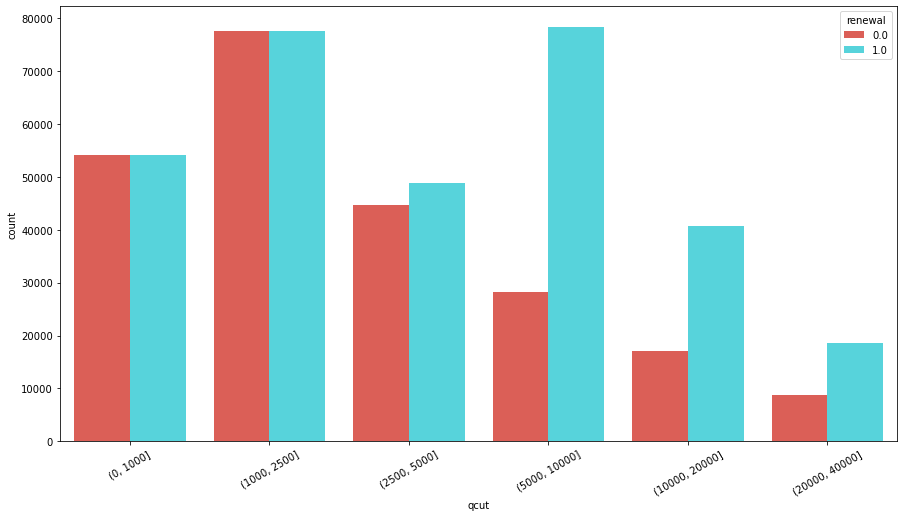

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
renewed_leases = renewal.copy()
cut_bins = [0, 1000, 2500, 5000, 10000, 20000, 40000]
renewed_leases['qcut'] = pd.cut(renewed_leases['rba'], bins=cut_bins)

df = renewed_leases.groupby(['qcut', 'renewal']).rba.count().reset_index().\
    rename(columns={'rba': 'count'})
# Fixed to show distribution of bin
df

# # create plot
plt.figure(figsize = (15,8))
ax=sns.barplot(x = 'qcut', y = 'count', hue = 'renewal', data = df,
            palette = 'hls',
           # order = ['male', 'female'],  
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)